# <center> 作业四 AFQMC </center>
by Hyr1sky_He

_为了提高任务效率，本ipynb中不再细化每个步骤的操作过程，仅记录重要思路及核心方法，Task题目解答将在实验报告中给出_

In [220]:
import math
import os
import numpy as np
import pandas as pd
import torch
import json
import jieba
from matplotlib import pyplot as plt
from torch import nn
from d2l import torch as d2l
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [221]:
# read json & vocab
def check_data(path):
    for dir_name, _, file_names in os.walk(path):
        for file_name in file_names:
            print(os.path.join(dir_name, file_name))

check_data('../Assignment4_dataset/data/')

../Assignment4_dataset/data/vocab.txt
../Assignment4_dataset/data/AFQMC数据集\dev.csv
../Assignment4_dataset/data/AFQMC数据集\dev.json
../Assignment4_dataset/data/AFQMC数据集\test.json
../Assignment4_dataset/data/AFQMC数据集\train.csv
../Assignment4_dataset/data/AFQMC数据集\train.json


In [222]:
# data processing
def read_data(path, type):
    sentence_1 = []
    sentence_2 = []
    label = []
    with open (path, 'r', encoding = 'utf-8') as f:
        for line in f.readlines():
            line = json.loads(line)
            sentence_1.append(line['sentence1'])
            sentence_2.append(line['sentence2'])
            if type != 'test':
                label.append(line['label'])
        if type != 'test':
            df = pd.DataFrame({'sentence1': sentence_1, 'sentence2': sentence_2, 'label': label})
        else:
            df = pd.DataFrame({'sentence1': sentence_1, 'sentence2': sentence_2})
    return df

In [223]:
def write_df(path, type):
    df = read_data(path, type)
    df.to_csv('../Assignment4_dataset/data/AFQMC数据集/' + type + '.csv', index = False)
    return "Generate csv file successfully!"

train_df = read_data('../Assignment4_dataset/data/AFQMC数据集/train.json', 'train')
train_df.head()

,sentence1,sentence2,label
0,蚂蚁借呗等额还款可以换成先息后本吗,借呗有先息到期还本吗,0
1,蚂蚁花呗说我违约一次,蚂蚁花呗违约行为是什么,0
2,帮我看一下本月花呗账单有没有结清,下月花呗账单,0
3,蚂蚁借呗多长时间综合评估一次,借呗得评估多久,0
4,我的花呗账单是***，还款怎么是***,我的花呗，月结出来说让我还***元，我自己算了一下详细名单我应该还***元,1


In [224]:
write_df('../Assignment4_dataset/data/AFQMC数据集/train.json', 'train')

'Generate csv file successfully!'

In [225]:
dev_df = read_data('../Assignment4_dataset/data/AFQMC数据集/dev.json', 'dev')
dev_df.head()

,sentence1,sentence2,label
0,双十一花呗提额在哪,里可以提花呗额度,0
1,花呗支持高铁票支付吗,为什么友付宝不支持花呗付款,0
2,我的蚂蚁花呗支付金额怎么会有限制,我到支付宝实体店消费用花呗支付受金额限制,1
3,为什么有花呗额度不能分期付款,花呗分期额度不足,0
4,赠品不能设置用花呗付款,怎么不能花呗分期付款,0


In [226]:
write_df('../Assignment4_dataset/data/AFQMC数据集/dev.json', 'dev')

'Generate csv file successfully!'

In [227]:
test_df = read_data('../Assignment4_dataset/data/AFQMC数据集/test.json', 'test')
test_df.head()

,sentence1,sentence2
0,借呗什么时候会取消,蚂蚁借呗什么时候可以恢复***个月
1,网商贷怎么转变成借呗,如何将网商贷切换为借呗
2,我的借呗为啥开通不了,我怎么没法开通借呗
3,蚂蚁借呗额度怎么不显示了,蚂蚁借呗额度不显示了
4,我的借呗没用给关闭了,把我的借呗关了


In [228]:
(train_df.sentence1.str.len() + train_df.sentence2.str.len()).describe()

count    34334.000000
mean        26.732597
std         10.405410
min         10.000000
25%         20.000000
50%         25.000000
75%         30.000000
max        157.000000
dtype: float64

In [229]:
with open('../Assignment4_dataset/data/vocab.txt', 'r', encoding='utf-8') as f:
    vocab = [line.strip() for line in f]

# mapping to id
char_to_id = {char: idx for idx, char in enumerate(vocab)}

# tokenize_sample
sentence_11 = "蚂蚁借呗等额还款可以换成先息后本吗"
sentence_22 = "借呗有先息到期还本吗"
sentence11_ids = [char_to_id.get(char, char_to_id['[UNK]']) for char in sentence_11]
print(sentence11_ids)
sentence22_ids = [char_to_id.get(char, char_to_id['[UNK]']) for char in sentence_22]
print(sentence22_ids)
sentence_ids = [char_to_id['[CLS]']] + sentence11_ids + [char_to_id['[SEP]']] + sentence22_ids + [char_to_id['[SEP]']]
print(sentence_ids)

[3802, 2975, 1051, 4947, 43, 852, 201, 699, 48, 22, 806, 33, 254, 399, 49, 89, 1114]
[1051, 4947, 9, 254, 399, 45, 195, 201, 89, 1114]
[1, 3802, 2975, 1051, 4947, 43, 852, 201, 699, 48, 22, 806, 33, 254, 399, 49, 89, 1114, 2, 1051, 4947, 9, 254, 399, 45, 195, 201, 89, 1114, 2]


In [230]:
BATCH_SIZE = 64
NUM_HIDDENS = 256
NUM_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.1
MAX_LEN = 164
NUM_EPOCHS = 20
LR = 0.001

In [231]:
class TextDataset(Dataset):
    def __init__(self, dataframe, char_to_id, max_length=MAX_LEN):
        self.data = dataframe
        self.char_to_id = char_to_id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence1 = self.data.iloc[index]['sentence1']
        sentence2 = self.data.iloc[index]['sentence2']
        if 'label' in self.data.columns:
            label = self.data.iloc[index]['label']
        label = int(label)

        combined_tokens = ['[CLS]'] + [char for char in sentence1] + ['[SEP]'] + [char for char in sentence2] + ['[SEP]']
        segment_ids = [0] * (len(sentence1) + 2) + [1] * (len(sentence2) + 1)

        combined_ids = [self.char_to_id.get(char, self.char_to_id['[UNK]']) for char in combined_tokens]
        combined_ids = torch.nn.functional.pad(torch.tensor(combined_ids), (0, self.max_length - len(combined_ids)))
        segment_ids = torch.nn.functional.pad(torch.tensor(segment_ids), (0, self.max_length - len(segment_ids)))
        # label = torch.tensor(label)

        return combined_ids, segment_ids, label

train_dataset = TextDataset(train_df, char_to_id)
dev_dataset = TextDataset(dev_df, char_to_id)
test_dataset = TextDataset(test_df, char_to_id)

def collate_fn(batch_data, pad_val=0, max_seq_len=MAX_LEN):
    input_ids, segment_ids, labels = [], [], []
    max_len = 0
    for example in batch_data:
        input_id, segment_id, label = example
        # cut
        input_ids.append(input_id[:max_seq_len])
        segment_ids.append(segment_id[:max_seq_len])
        labels.append(label)
        # max
        max_len = max(max_len, len(input_id))
    # pad
    for i in range(len(labels)):
        input_ids[i] = torch.cat([input_ids[i], torch.tensor([pad_val] * (max_len - len(input_ids[i])))])
        segment_ids[i] = torch.cat([segment_ids[i], torch.tensor([pad_val] * (max_len - len(segment_ids[i])))])

    return torch.stack(input_ids), torch.stack(segment_ids), torch.tensor(labels)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# mini-batch
print("mini-batch sample:")
for idx, item in enumerate(train_dataloader):
    if idx == 0:
        print(item)
        break

mini-batch sample:
(tensor([[1.0000e+00, 4.6200e+02, 2.6430e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 7.0000e+00, 2.7000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.4200e+02, 2.2800e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0000e+00, 1.0510e+03, 4.9470e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 8.8000e+01, 1.2400e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.3000e+01, 6.1400e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0

In [232]:
class WordEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx=0):
        super(WordEmbedding, self).__init__()
        self.emb_size = emb_size
        self.word_embedding = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        nn.init.normal_(self.word_embedding.weight, mean=0.0, std=emb_size ** -0.5)

    def forward(self, word):
        word_emb = (self.emb_size ** 0.5) * self.word_embedding(word)
        return word_emb

# sample
vocab_size = 10000
emb_size = 300
padding_idx = 0

word_embedding = WordEmbedding(vocab_size, emb_size, padding_idx)
input_word = torch.tensor([1, 2, 3, 4])
output_embedding = word_embedding(input_word)
print(output_embedding)

tensor([[ 0.2551, -0.1008,  1.0827,  ...,  0.2031, -1.5132, -0.0033],
        [ 1.4436, -0.7597, -0.2470,  ..., -0.1384,  1.2034, -1.3039],
        [-1.7262, -1.7636, -0.2379,  ...,  0.0985,  1.7969,  0.3163],
        [ 0.1847,  0.0230,  0.2470,  ..., -0.2437,  1.1850,  1.2422]],
       grad_fn=<MulBackward0>)


In [233]:
class SegmentEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SegmentEmbedding, self).__init__()
        self.emb_size = emb_size
        self.seg_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)

    def forward(self, word):
        seg_embedding = self.seg_embedding(word)
        return seg_embedding
    
# sample
vocab_size = 2
emb_size = 300

segment_embedding = SegmentEmbedding(vocab_size, emb_size)
input_segment = torch.tensor([0, 1, 0, 1])
output_embedding = segment_embedding(input_segment)
print(output_embedding)

tensor([[ 1.2929, -0.8619, -2.0534,  ...,  0.6956, -0.0449, -1.2751],
        [ 1.5968,  1.3953, -0.0699,  ..., -0.6082,  2.1202, -0.2991],
        [ 1.2929, -0.8619, -2.0534,  ...,  0.6956, -0.0449, -1.2751],
        [ 1.5968,  1.3953, -0.0699,  ..., -0.6082,  2.1202, -0.2991]],
       grad_fn=<EmbeddingBackward0>)


In [234]:
def get_sinusoid_encoding(position_size, hidden_size):
    def cal_angle(pos, hidden_idx):
        return pos / np.power(10000, 2 * (hidden_idx // 2) / hidden_size)

    def get_posi_angle_vec(pos):
        return [cal_angle(pos, hidden_j) for hidden_j in range(hidden_size)]

    sinusoid = np.array([get_posi_angle_vec(pos_i) for pos_i in range(position_size)])
    sinusoid[:, 0::2] = np.sin(sinusoid[:, 0::2])
    sinusoid[:, 1::2] = np.cos(sinusoid[:, 1::2])
    return torch.tensor(sinusoid, dtype=torch.float32)

class PositionalEmbedding(nn.Module):
    def __init__(self, max_length, emb_size):
        super(PositionalEmbedding, self).__init__()
        self.emb_size = emb_size
        self.max_length = max_length
        self.register_buffer('pos_encoder', get_sinusoid_encoding(max_length, self.emb_size))
    
    def forward(self, pos):
        # Ensure that pos is within valid range
        pos = torch.clamp(pos, 0, self.max_length - 1)
        pos_emb = self.pos_encoder[pos]
        pos_emb = pos_emb.detach()  # Detach so gradients are not computed
        return pos_emb

# ex
out = torch.randint(low=0, high=5, size=[3])
print('输入向量为：{}'.format(out.numpy()))

pos_embed = PositionalEmbedding(4, 5)
pos_out = pos_embed(out)
print('位置编码的输出为： {}'.format(pos_out.numpy()))

输入向量为：[2 4 1]
位置编码的输出为： [[ 9.0929741e-01 -4.1614684e-01  5.0216600e-02  9.9873835e-01
   1.2619144e-03]
 [ 1.4112000e-01 -9.8999250e-01  7.5285293e-02  9.9716204e-01
   1.8928709e-03]
 [ 8.4147096e-01  5.4030228e-01  2.5116222e-02  9.9968451e-01
   6.3095731e-04]]


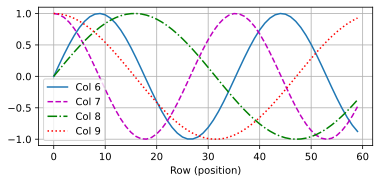

In [235]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEmbedding(num_steps, encoding_dim)
pos_encoding.eval()

sample = torch.randint(0, 100, (1, num_steps))
X = pos_encoding(sample)
P = pos_encoding.pos_encoder[:, :X.shape[1]]
d2l.plot(torch.arange(num_steps), P[:, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [236]:
class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, hidden_dropout_prob, position_size, segment_size):
        super(TransformerEmbeddings, self).__init__()
        self.word_embeddings = WordEmbedding(vocab_size, hidden_size)
        self.position_embeddings = PositionalEmbedding(position_size, hidden_size)
        self.segment_embeddings = SegmentEmbedding(segment_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, input_ids, segment_ids=None, position_ids=None):
        if position_ids is None:
            ones = torch.ones_like(input_ids, dtype=torch.long)
            seq_length = torch.cumsum(ones, dim=-1)
            position_ids = seq_length - ones
            position_ids = position_ids.clamp(0, self.position_embeddings.max_length - 1)

        input_embeddings = self.word_embeddings(input_ids)
        segment_embeddings = self.segment_embeddings(segment_ids)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = input_embeddings + segment_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        embeddings = embeddings.to(torch.float32)
        return embeddings

In [237]:
# sample
vocab_size = 10000
hidden_size = 256
position_size = 512
segment_size = 2
dropout = 0.1

transformer_embeddings = TransformerEmbeddings(vocab_size, hidden_size, dropout, position_size, segment_size)

input_ids = torch.randint(0, vocab_size, (1, 10))
segment_ids = torch.randint(0, segment_size, (1, 10))
position_ids = None

# forward
output_embeddings = transformer_embeddings(input_ids, segment_ids, position_ids)

print("Output Embeddings Shape:", output_embeddings.shape)

Output Embeddings Shape: torch.Size([1, 10, 256])


In [238]:
# Feed Forward
# Actually, it's a two-layer MLP
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, pw_num_outputs, **kwargs) -> None:
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, pw_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [239]:
ffn = PositionWiseFFN(4, 4, 12)
ffn.eval()
print(ffn)
ffn(torch.ones((2, 3, 4)))[0]

PositionWiseFFN(
  (dense1): Linear(in_features=4, out_features=4, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=4, out_features=12, bias=True)
)


tensor([[ 0.0116,  0.5948, -0.3747, -0.4487,  0.1246, -0.6740,  0.3477, -0.8027,
          0.0212, -0.0281, -0.3445, -0.3816],
        [ 0.0116,  0.5948, -0.3747, -0.4487,  0.1246, -0.6740,  0.3477, -0.8027,
          0.0212, -0.0281, -0.3445, -0.3816],
        [ 0.0116,  0.5948, -0.3747, -0.4487,  0.1246, -0.6740,  0.3477, -0.8027,
          0.0212, -0.0281, -0.3445, -0.3816]], grad_fn=<SelectBackward0>)

In [240]:
class AddNorm(nn.Module): 
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [241]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [242]:
def transpose_qkv(X, num_heads):
    """Note
    For parrallel computation, we can concat the heads together
    INPUT: X.shape = (batch_size, num_steps, num_hiddens)
    OUTPUT: X.shape = (batch_size * num_heads, num_steps, num_hiddens/num_heads)
    combine the num_heads and num_hiddens/num_heads together
    """
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    print(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Note
    Inverse of transpose_qkv
    INPUT: X.shape = (batch_size * num_heads, num_steps, num_hiddens/num_heads)
    OUTPUT: X.shape = (batch_size, num_steps, num_hiddens)
    """
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [243]:
class multiheadAttention (nn.Module):
    def __init__(self, query_size, key_size, value_size,
                 num_hiddens, num_heads, dropout, bias=False, 
                 *args, **kwargs) -> None:
        super(multiheadAttention, self).__init__(*args, **kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        """Note
        concat all the heads together for matrix multiplication
        """
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [244]:
# Test
num_hiddens, num_heads = 100, 5 
attention = multiheadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()
print(attention)

batch_size, num_steps = 2, 4
num_kvpairs, valid_lens = 2, torch.tensor([3, 2])
X = torch.ones((batch_size, num_steps, num_hiddens))
Y = torch.ones((batch_size, num_steps, num_hiddens))
attention(X, Y, Y, valid_lens).shape

multiheadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)
2 5 4 20
2 5 4 20
2 5 4 20


torch.Size([2, 4, 100])

In [245]:
class EncoderBlock(nn.Module):
    def __init__(self, query_size, key_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs) -> None:
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = multiheadAttention(query_size, key_size, value_size, num_hiddens, num_heads, dropout, bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        attention_output, attention_weights = self.attention(X, X, X, valid_lens) 
        Y = self.addnorm1(X, attention_output)  # self-attention
        return self.addnorm2(Y, self.ffn(Y))

In [246]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

2 8 100 3
2 8 100 3
2 8 100 3


torch.Size([2, 100, 24])

In [247]:
"""
- Self-Attention
- Add & Norm
- Feed Forward
- Add & Norm
- Encoder Block
"""
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = TransformerEmbeddings(vocab_size, num_hiddens, dropout, position_size=MAX_LEN, segment_size=2)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            # print(X.shape)
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
            print(f"Intermediate Output Shape after Block {i}: {X.shape}")
            print(self.attention_weights[i].shape)
        return X

In [248]:
class eee(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(eee, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Because the value of positional codes are always between -1 and 1,
        # So we scale the embedding with sqrt of the num_hiddens
        # Then add the positional encoding
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X
    
encoder = eee(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

2 8 100 3
2 8 100 3
2 8 100 3
2 8 100 3
2 8 100 3
2 8 100 3


torch.Size([2, 100, 24])

In [249]:
# Two layer Transformer Encoder
batch_size = 2
max_seq_length = 50
transformer_embeddings = TransformerEmbeddings(vocab_size=200, 
                                               hidden_size=24, 
                                               hidden_dropout_prob=0.1, 
                                               position_size=100, 
                                               segment_size=2)

input_ids = torch.randint(0, 200, (batch_size, max_seq_length))
segment_ids = torch.randint(0, 2, (batch_size, max_seq_length))
position_ids = None

embeddings_output = transformer_embeddings(input_ids, segment_ids, position_ids)
valid_lens = torch.randint(1, max_seq_length + 1, (batch_size,))

transformer_encoder = TransformerEncoder(vocab_size=200, 
                                         key_size=24, 
                                         query_size=24, 
                                         value_size=24, 
                                         num_hiddens=24, 
                                         norm_shape=[2, 50, 24], 
                                         ffn_num_input=24, 
                                         ffn_num_hiddens=48, 
                                         num_heads=8, 
                                         num_layers=2,
                                         dropout=0.5)

output = transformer_encoder(embeddings_output, valid_lens)
print("Input Embeddings Shape:", embeddings_output.shape)
print("Output Shape:", output.shape)

2 8 50 3
2 8 50 3
2 8 50 3
Intermediate Output Shape after Block 0: torch.Size([2, 50, 24])
torch.Size([16, 50, 50])
2 8 50 3
2 8 50 3
2 8 50 3
Intermediate Output Shape after Block 1: torch.Size([2, 50, 24])
torch.Size([16, 50, 50])
Input Embeddings Shape: torch.Size([2, 50, 24])
Output Shape: torch.Size([2, 50, 24])


In [250]:
# Train
# get train_dataset size
train_size = len(train_dataset)
dev_size = len(dev_dataset)
test_size = len(test_dataset)
print("train size:", train_size)
print("dev size:", dev_size)
print("test size:", test_size)

train size: 34334
dev size: 4316
test size: 3861


In [255]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# Padding index
padding_idx = char_to_id['[PAD]']

# Define Transformer Embeddings
transformer_embeddings = TransformerEmbeddings(
    vocab_size=train_size,
    hidden_size=NUM_HIDDENS,
    hidden_dropout_prob=DROPOUT,
    position_size=MAX_LEN,
    segment_size=2
)

# Define Transformer Encoder
model = TransformerEncoder(
    vocab_size=train_size,
    key_size=NUM_HIDDENS,
    query_size=NUM_HIDDENS,
    value_size=NUM_HIDDENS,
    num_hiddens=NUM_HIDDENS,
    norm_shape=[2, MAX_LEN, NUM_HIDDENS],
    ffn_num_input=NUM_HIDDENS,
    ffn_num_hiddens=NUM_HIDDENS * 2,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    use_bias=False
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=5E-5,
    weight_decay=0.0
)

# Training loop
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    model.train()
    for batch_data in train_dataloader:
        combined_ids, segment_ids, labels = batch_data
        
        # 将 combined_ids 转换为 torch.LongTensor
        combined_ids = combined_ids.long()

        embeddings_output = transformer_embeddings(combined_ids, segment_ids)
        valid_lens = None
        outputs = model(embeddings_output, valid_lens)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_data in dev_dataloader:
            combined_ids, segment_ids, labels = batch_data
            outputs = model(combined_ids, segment_ids)
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_val_loss = val_loss / len(dev_dataloader)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {average_val_loss}, Accuracy: {accuracy}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)